In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy as np
import math as mt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from PIL import Image

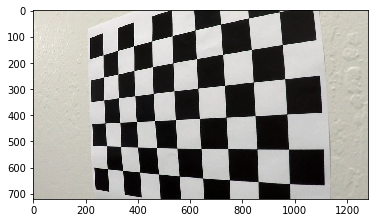

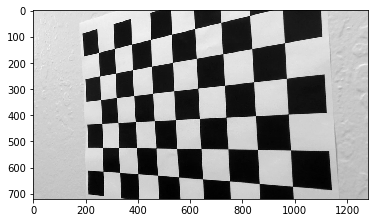

In [2]:
## Calibration matrix calculation
images = glob.glob('camera_cal\calibration*.jpg')
img_points = []
obj_points = []
for image in images:
    image = mpimg.imread(image)
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_size = image_gray.shape
    ret, corners = cv2.findChessboardCorners(image_gray, (9,6))
    obj_point = np.zeros((9*6,3), dtype=np.float32)
    obj_point[:,:2] = np.mgrid[0:9, 0:6].T.reshape((-1,2))
    if ret == True:
        img_points.append(corners)
        obj_points.append(obj_point)

ret, mat, coeff, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (image_size[1], image_size[0]), None, None)
img1 = mpimg.imread('camera_cal\calibration4.jpg')
plt.imshow(img1, cmap='gray')
plt.show()
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
dst = cv2.undistort(img1_gray, mat, coeff, None, mat)
plt.imshow(dst, cmap ='gray')
plt.show()

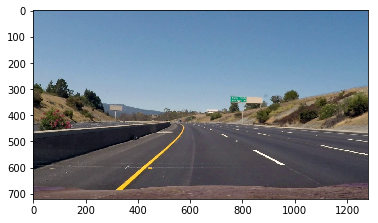

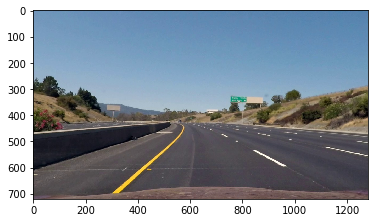

In [3]:
img_video = mpimg.imread('video_images/project_video/frame0.jpg')
plt.imshow(img_video)
plt.show()
img_video_undist = cv2.undistort(img_video, mat, coeff, None, mat)
plt.imshow(img_video_undist)
plt.show()

In [4]:
## Apply thresholding to gradients

def gradient_threshold(img, gradx_thresh=(70,255), s_thresh=(50, 255)):      
    img_size = (img.shape[1], img.shape[0])
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=5))
    sobelx = np.uint8(255 * sobelx/np.max(sobelx))
    gradx_binary = np.zeros_like(sobelx)
    gradx_binary[(sobelx > gradx_thresh[0]) & (sobelx <= gradx_thresh[1])] = 1
    
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_s = img_hls[:,:,2]
    sobel_s = np.absolute(cv2.Sobel(img_s, cv2.CV_64F, 0, 1, ksize=9))
    sobel_s = np.uint8(255 * sobel_s/np.max(sobel_s))
    grads_binary = np.zeros_like(sobel_s)
    grads_binary[(sobel_s > s_thresh[0]) & (sobel_s <= s_thresh[1])] = 1
    
    thresh_img = np.zeros_like(sobel_s)
    thresh_img[ (grads_binary == 1) | (gradx_binary == 1) ] = 1   
    
    return thresh_img

## Avoid trees etc
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
## define parameters
height = 720
width = 1280
img_size = (width, height)
margin = 75
margin_lane = 50
minpix = 500
nwindows = 12
mask_vertices = np.array([[(0.05*width,height),(0.47*width, 0.595*height), (0.52*width, 0.595*height), (0.95*width,height)]], dtype=np.int32)

### Use two transformation matrix. TransM2 is used initially, then TransM2
src_corners = np.array([[262, 681], [575, 460], [711, 460], [1047, 681]], dtype=np.float32)
dst_corners =  np.array([[362, 681], [350, 0], [959, 0], [947, 681]], dtype=np.float32)
TransM1 = cv2.getPerspectiveTransform(src_corners, dst_corners)
TransMinv1 = cv2.getPerspectiveTransform(dst_corners, src_corners)

src_corners = np.array([[278, 660], [408, 572], [882, 572], [1031, 660]], dtype=np.float32)
dst_corners =  np.array([[362, 660], [362, 0], [947, 0], [947, 660]], dtype=np.float32)
TransM2 = cv2.getPerspectiveTransform(src_corners, dst_corners)
TransMinv2 = cv2.getPerspectiveTransform(dst_corners, src_corners)


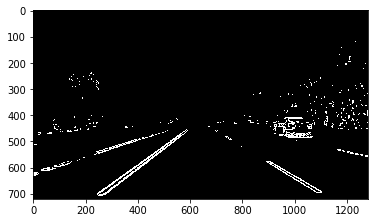

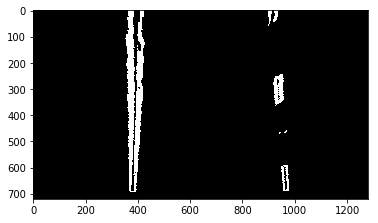

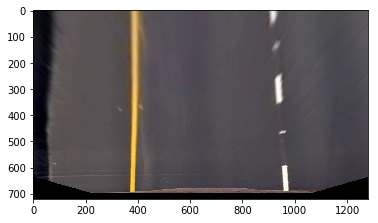

In [12]:
img_video = mpimg.imread('video_images/project_video/frame420.jpg')
img_video_undist = cv2.undistort(img_video, mat, coeff, None, mat)
thresh_img = gradient_threshold(img_video_undist)
plt.imshow(thresh_img, cmap = 'gray')
plt.show()
thresh_img = region_of_interest(thresh_img, mask_vertices)
top_view_image = cv2.warpPerspective(thresh_img, TransM1, (width, height), flags=cv2.INTER_LINEAR)
top_view_image = top_view_image * 255
final_result = np.dstack((top_view_image, top_view_image, top_view_image))
plt.imshow(final_result, cmap = 'gray')
plt.show()
top_view_image1 = cv2.warpPerspective(img_video_undist, TransM1, (width, height), flags=cv2.INTER_LINEAR)
plt.imshow(top_view_image1)
plt.show()

In [13]:
## calculate mean squared error for a fit
def get_rsquare(y,x,fit):
    xfit = fit[0]*y**2 + fit[1]*y + fit[2]
    sum_res = np.sum((xfit - x)**2)    
    return (sum_res/len(xfit))

## decay function
def decay_function(T, x0, rate):
    x1 = x0 * (1-rate)
    lam = (1/T) * mt.log(x0/x1)
    K = x0    
    out_val = [K * mt.exp(-lam * t) for t in range(T)]
    out_val = np.flipud(out_val)
    return out_val

## Lane width is 600 pixels
xm_per_pix = 3.7/600 # meters per pixel in x dimension

### The top view transformation covers roughly three white lines with spaces - 2 * 30 + 3* 10 ~100 ft = 30 m 
ym_per_pix = 30/720 # meters per pixel in y dimension


In [14]:
## Apply sliding window technique to find lane lines
## First, get a thresholded image and get a top view
## Use sliding window to find points near the lane and fit a 2nd order polynomial

def findLanes_slidingwindow(leftlane, rightlane, undist_img, TransM):
    thresh_img = region_of_interest(gradient_threshold(undist_img), mask_vertices)
    top_view_binary = cv2.warpPerspective(thresh_img, TransM, img_size, flags=cv2.INTER_LINEAR)
    
    ### Fit lanes for first frame

    histogram = np.sum(top_view_binary[top_view_binary.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
        
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint    
       
    if leftlane.lane_width > 0 and leftlane.curframenum > 10:
        est_left_end = (leftlane.lane_center - (leftlane.lane_width//2))
        est_right_end = (leftlane.lane_center + (leftlane.lane_width//2))
        
        if (leftx_base <= (est_left_end + margin_lane)) and (leftx_base >= (est_left_end - margin_lane)):
            leftx_base = leftx_base
        else:
            leftx_base = est_left_end        
        
        if (rightx_base <= (est_right_end + margin_lane)) and (rightx_base >= (est_right_end - margin_lane)):
            rightx_base= rightx_base
        else:
            rightx_base = est_right_end    
    
    window_height = np.int(top_view_binary.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    white_pixels = top_view_binary.nonzero()
    white_pixels_y = np.array(white_pixels[0])
    white_pixels_x = np.array(white_pixels[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = [] 
    left_cnt = 0
    right_cnt = 0
    out_img = np.dstack((top_view_binary, top_view_binary, top_view_binary))*255
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = top_view_binary.shape[0] - (window+1)*window_height
        win_y_high = top_view_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((white_pixels_y >= win_y_low) & (white_pixels_y < win_y_high) & (white_pixels_x >= win_xleft_low) & (white_pixels_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((white_pixels_y >= win_y_low) & (white_pixels_y < win_y_high) & (white_pixels_x >= win_xright_low) & (white_pixels_x < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position        
        if len(good_left_inds) > minpix:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,255,0), 2) 
            leftx_current = np.int(np.mean(white_pixels_x[good_left_inds]))
            left_cnt = left_cnt + 1
        if len(good_right_inds) > minpix:
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,255,0), 2)
            rightx_current = np.int(np.mean(white_pixels_x[good_right_inds]))
            right_cnt = right_cnt + 1

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = white_pixels_x[left_lane_inds]
    lefty = white_pixels_y[left_lane_inds] 
    rightx = white_pixels_x[right_lane_inds]
    righty = white_pixels_y[right_lane_inds]
    out_img[white_pixels_y[left_lane_inds], white_pixels_x[left_lane_inds]] = [255, 0, 0]
    out_img[white_pixels_y[right_lane_inds], white_pixels_x[right_lane_inds]] = [0, 0, 255]
    
    left_conf = left_cnt/nwindows
    right_conf = right_cnt/nwindows

    fit_right = False
    fit_left = False
    left_fit_new = [-1, -1, -1]
    right_fit_new = [-1. -1, -1]
    left_curverad = -1
    right_curverad = -1
    left_r2 = -1
    right_r2 = -1
    
    # Fit a second order polynomial to each
    
    if len(lefty) > 0 and len(leftx) > 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)        
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*height*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        if len(left_fit_new) == 3:
            fit_left = True
            left_r2 = get_rsquare(lefty, leftx, left_fit_new)
        
    if len(righty) > 0 and len(rightx) > 0:       
        right_fit_new = np.polyfit(righty, rightx, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        right_curverad = ((1 + (2*right_fit_cr[0]*height*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        if len(right_fit_new) == 3:
            fit_right = True
            right_r2 = get_rsquare(righty, rightx, right_fit_new)
    
    if fit_left == False:
        left_conf = -1
        left_fit_new = [-1, -1, -1]
        left_curverad = -1
        
    if fit_right == False:
        right_conf = -1
        right_curverad = -1
        right_fit_new = [-1, -1, -1]
            
    return (left_fit_new, right_fit_new, left_curverad, right_curverad, left_conf, right_conf, left_r2, right_r2, out_img)


### Extrapolate lines obtained using previous frame and
### fit a second order polynomial again

def findLanes_extrapolate(leftlane, rightlane, undist_img, TransM):
    right_fit = rightlane.avg_fit[0]    
    left_fit = leftlane.avg_fit[0]

    thresh_img = region_of_interest(gradient_threshold(undist_img), mask_vertices)
    top_view_binary = cv2.warpPerspective(thresh_img, TransM, img_size, flags=cv2.INTER_LINEAR)
    # Identify the x and y positions of all nonzero pixels in the image
    white_pixels = top_view_binary.nonzero()
    white_pixels_y = np.array(white_pixels[0])
    white_pixels_x = np.array(white_pixels[1])
    ### Lane lines for subsequent frames
    left_lane_inds = ((white_pixels_x > (left_fit[0]*(white_pixels_y**2) + left_fit[1]*white_pixels_y + left_fit[2] - margin)) & (white_pixels_x < (left_fit[0]*(white_pixels_y**2) + left_fit[1]*white_pixels_y + left_fit[2] + margin))) 
    right_lane_inds = ((white_pixels_x > (right_fit[0]*(white_pixels_y**2) + right_fit[1]*white_pixels_y + right_fit[2] - margin)) & (white_pixels_x < (right_fit[0]*(white_pixels_y**2) + right_fit[1]*white_pixels_y + right_fit[2] + margin)))  

    left_cnt = 0
    right_cnt = 0
    window_height = np.int(top_view_binary.shape[0]/nwindows)    
    out_img = np.dstack((top_view_binary, top_view_binary, top_view_binary))*255    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = top_view_binary.shape[0] - (window+1)*window_height
        win_y_high = top_view_binary.shape[0] - window*window_height
        
        leftx_low = (left_fit[0]*(win_y_low**2) + left_fit[1]*win_y_low + left_fit[2])
        leftx_high = (left_fit[0]*(win_y_high**2) + left_fit[1]*win_y_high + left_fit[2])
        
        rightx_low = (right_fit[0]*(win_y_low**2) + right_fit[1]*win_y_low + right_fit[2])
        rightx_high = (right_fit[0]*(win_y_high**2) + right_fit[1]*win_y_high + right_fit[2])
        
        leftbox_low_x1 = leftx_low - margin
        leftbox_low_x2 =  leftx_low + margin        
        leftbox_high_x1 = leftx_high - margin
        leftbox_high_x2 =  leftx_high + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((white_pixels_y >= win_y_low) & (white_pixels_y < win_y_high) & (white_pixels_x >= leftbox_low_x1) & (white_pixels_x < leftbox_low_x2) & (white_pixels_x >= leftbox_high_x1) & (white_pixels_x < leftbox_high_x2)).nonzero()[0]
        
        rightbox_low_x1 = rightx_low - margin
        rightbox_low_x2 =  rightx_low + margin        
        rightbox_high_x1 = rightx_high - margin
        rightbox_high_x2 =  rightx_high + margin
        
        good_right_inds = ((white_pixels_y >= win_y_low) & (white_pixels_y < win_y_high) & (white_pixels_x >= rightbox_low_x1) & (white_pixels_x < rightbox_low_x2) & (white_pixels_x >= rightbox_high_x1) & (white_pixels_x < rightbox_high_x2)).nonzero()[0]
        
        ptsl = np.array([[leftbox_low_x1,win_y_low], [leftbox_low_x2,win_y_low], [leftbox_high_x2,win_y_high], [leftbox_high_x1,win_y_high]], np.int32)
        ptsl = ptsl.reshape((-1,1,2))
        cv2.polylines(out_img,[ptsl],True,(0,255,0), 2)       
        
        ptsr = np.array([[rightbox_low_x1,win_y_low], [rightbox_low_x2,win_y_low], [rightbox_high_x2,win_y_high], [rightbox_high_x1,win_y_high]], np.int32)
        ptsr = ptsr.reshape((-1,1,2))
        cv2.polylines(out_img,[ptsr],True,(0,255,0), 2) 
                        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            cv2.polylines(out_img,[ptsl],True,(255,255,255), 2)
            left_cnt = left_cnt + 1
        if len(good_right_inds) > minpix:
            cv2.polylines(out_img,[ptsr],True,(255,255,255), 2)
            right_cnt = right_cnt + 1        
       

    left_conf = left_cnt/nwindows
    right_conf = right_cnt/nwindows
    
    # Again, extract left and right line pixel positions    
    leftx = white_pixels_x[left_lane_inds]
    lefty = white_pixels_y[left_lane_inds] 
    rightx = white_pixels_x[right_lane_inds]
    righty = white_pixels_y[right_lane_inds]           
    out_img[white_pixels_y[left_lane_inds], white_pixels_x[left_lane_inds]] = [255, 0, 0]
    out_img[white_pixels_y[right_lane_inds], white_pixels_x[right_lane_inds]] = [0, 0, 255]
    
    fit_right = False
    fit_left = False
    left_fit_new = [-1, -1, -1]
    right_fit_new = [-1. -1, -1]
    left_curverad = -1
    right_curverad = -1
    left_r2 = -1
    right_r2 = -1
    
    # Fit a second order polynomial to each    
    
    if len(lefty) > 0 and len(leftx) > 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*height*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        if len(left_fit_new) == 3:
            fit_left = True
            left_r2 = get_rsquare(lefty, leftx, left_fit_new)
        
    if len(righty) > 0 and len(rightx) > 0:       
        right_fit_new = np.polyfit(righty, rightx, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        right_curverad = ((1 + (2*right_fit_cr[0]*height*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        if len(right_fit_new) == 3:
            fit_right = True
            right_r2 = get_rsquare(righty, rightx, right_fit_new)
    
    if fit_left == False:
        left_conf = -1
        left_fit_new = [-1, -1, -1]
        left_curverad = -1
        
    if fit_right == False:
        right_conf = -1
        right_curverad = -1
        right_fit_new = [-1, -1, -1]   
            
    return (left_fit_new, right_fit_new, left_curverad, right_curverad, left_conf, right_conf, left_r2, right_r2, out_img)

### Pipeline function
### Takes an undistorted image as input, and applies sliding window and/or
### extrapolation to find a polynomial to fit lane lines.
### It uses two measures to fit a quality of fit:
### 1) conf val - 0 to 1, representing number of points use to fit the polynomial
### 2) r2 value - mean square of fit
### Every time a good line is detected for left lane and/or right lange, they 
### are stored in line objects passsed as input. The line objects also stores the average
### If it finds good fits for left and right lane, then it use both. Else if
### it finds good line for one lane, it uses that and fits the other line using
### estimated lane width. If both lines are not good, then it uses average fit for both.
### Pipeline returns the un-warped image with lane area identified. It also returns
### thresholded image with polynomial fits.


def Pipeline(leftlane, rightlane, undist_img):
    #print(leftlane.curframenum, rightlane.curframenum, leftlane.lane_width, leftlane.lane_center)
    #print(leftlane.lane_fit, leftlane.avg_fit, rightlane.lane_fit, rightlane.avg_fit)    
    TransM = TransM1
    TransMinv = TransMinv1  
    
    if (leftlane.curframenum < 10) or leftlane.detected == False or rightlane.detected == False:
        left_fit, right_fit, left_cr, right_cr, left_conf, right_conf, left_r2, right_r2, out_img = findLanes_slidingwindow(leftlane, rightlane, undist_img, TransM)
    else:
        left_fit, right_fit, left_cr, right_cr, left_conf, right_conf, left_r2, right_r2, out_img = findLanes_extrapolate(leftlane, rightlane, undist_img, TransM)
        
        if left_conf <= 0.7 or right_conf <= 0.5:
            left_fit_tmp, right_fit_tmp, left_cr_tmp, right_cr_tmp, left_conf_tmp, right_conf_tmp, left_r2_tmp, right_r2_tmp, out_img_tmp = findLanes_slidingwindow(leftlane, rightlane, undist_img, TransM) 
            if left_conf_tmp > left_conf:
                left_fit, left_cr, left_conf, left_r2, out_img = left_fit_tmp, left_cr_tmp, left_conf_tmp, left_r2_tmp, out_img_tmp
            elif right_conf_tmp > right_conf:
                right_fit, right_cr, right_conf, right_r2, out_img = right_fit_tmp, right_cr_tmp, right_conf_tmp, right_r2_tmp, out_img_tmp
                
    ## if left and right confidence are both close to 1 then update lane width and lane center
       
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]   
    diff_x = right_fitx - left_fitx    
    parallel_measure = (abs((max(diff_x) - min(diff_x))/(min(diff_x))))
    #print(left_conf, right_conf, left_r2, right_r2, parallel_measure) 
    
    if ((left_conf > 0.9) or (right_conf > 0.9)) and (parallel_measure <= 0.2):
        left_lane_pt = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
        right_lane_pt = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]   
        if leftlane.curframenum < 10:      
            leftlane.update_lane_width(right_lane_pt - left_lane_pt)       
            rightlane.update_lane_width(right_lane_pt - left_lane_pt)
            leftlane.lane_center = np.int((right_lane_pt + left_lane_pt)//2)
            rightlane.lane_center = np.int((right_lane_pt + left_lane_pt)//2)
                            
    found_fit = False
    cur_left_fit = [-1, -1, -1]
    cur_right_fit = [-1, -1, -1]    
    ref_text = ''
    if ((left_conf >= 0.5) or (right_conf >= 0.5)) and (parallel_measure <= 0.2):
        cur_left_fit = leftlane.add_fit([left_fit, left_conf])
        cur_right_fit = rightlane.add_fit([right_fit, right_conf])
        #if left_conf > 0:
        #    leftlane.add_fit([left_fit, left_conf])
        #if right_conf > 0:
        #    rightlane.add_fit([right_fit, right_conf]) 
        reference = 'both'
        found_fit = True
        #print('using latest')
        ref_text = 'found good fit for both'  
    else:    
        cur_left_fit = leftlane.avg_fit[0]
        cur_right_fit = rightlane.avg_fit[0]
        reference = 'both'
        found_fit = True
        #print('using avg for both')
        ref_text = 'using avg for both'
        
    
    if found_fit == False:
        return undist_img

    ploty = np.linspace(0, height-1, height)
    left_text = ''
    right_text = ''
    
    if reference == 'both':
        left_fitx = cur_left_fit[0]*ploty**2 + cur_left_fit[1]*ploty + cur_left_fit[2]                    
        right_fitx = cur_right_fit[0]*ploty**2 + cur_right_fit[1]*ploty + cur_right_fit[2]
        left_text = 'Left: ' + str(int(left_cr)) + '(m)'
        right_text = 'Right: ' + str(int(right_cr)) + '(m)' 
    elif reference == 'left':
        left_fitx = cur_left_fit[0]*ploty**2 + cur_left_fit[1]*ploty + cur_left_fit[2]                     
        right_fitx = left_fitx + decay_function(len(left_fitx), leftlane.lane_width, 0.2)
        right_fit_usingleft = np.polyfit(ploty, right_fitx, 2)
        rightlane.add_fit([right_fit_usingleft, left_conf])
        left_text = 'Left: ' + str(int(left_cr)) + '(m)'
    elif reference == 'right':
        right_fitx = cur_right_fit[0]*ploty**2 + cur_right_fit[1]*ploty + cur_right_fit[2]                     
        left_fitx = right_fitx - decay_function(len(right_fitx), leftlane.lane_width, 0.2)
        left_fit_usingright = np.polyfit(ploty, left_fitx, 2)
        leftlane.add_fit([left_fit_usingright, right_conf])
        right_text = 'Right: ' + str(int(right_cr)) + '(m)'
        
    deviation = (width//2 - (int(right_fitx[height-1]) + int(left_fitx[height-1]))// 2) * xm_per_pix
    if deviation < 0:
        dev_text = 'Vehicle located ' + format(abs(deviation), '0.2f') + '(m) right of center'
    elif deviation > 0:
        dev_text = 'Vehicle located ' + format(abs(deviation), '0.2f') + '(m) left of center'
    else:
        dev_text = 'Vehicle located in center'
        
        
    color_warp = np.zeros_like(undist_img)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    warped_lanes = cv2.warpPerspective(color_warp, TransMinv, img_size, flags=cv2.INTER_LINEAR)
    final_result = cv2.addWeighted(undist_img, 1, warped_lanes, 0.3, 0) 
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final_result, left_text,(10,75), font, 1.5,(255,0,0), 4, cv2.LINE_AA)
    cv2.putText(final_result, right_text,(10,150), font, 1.5,(255,0,0), 4, cv2.LINE_AA)
    cv2.putText(final_result, dev_text,(10,225), font, 1.5,(255,0,0), 4, cv2.LINE_AA)
    
    leftlane.curframenum = leftlane.curframenum + 1
    rightlane.curframenum = rightlane.curframenum + 1
    lines_img = np.zeros_like(undist_img)
    ##print(pts_left[0:10])
    left_fitx[left_fitx < 0] = 0
    left_fitx[left_fitx >= width-1] = width-1
    right_fitx[right_fitx < 0] = 0
    right_fitx[right_fitx >= width-1] = width-1 
    lines_img[np.int_(ploty), np.int_(left_fitx),:] = (255, 255, 0)
    lines_img[np.int_(ploty), np.int_(right_fitx),:] = (255, 255, 0)    
    out_img = cv2.addWeighted(lines_img, 1, out_img, 1, 0)
    #print(leftlane.avg_fit[0], rightlane.avg_fit[0])
    return final_result, out_img

In [15]:
## Line class. Line object stores upto 'K' previous lines. In addition,
## it also stores estimate lane center and lane width
class Line():
    def __init__(self, K):
        self.detected = False
        self.lane_fit = []
        self.avg_fit = []
        self.maxsize = K
        self.lane_width = -1
        self.lane_center = width // 2
        self.curframenum = 0
        self.lastbestframenum = 0
        self.lane_width_values = [] 
    def add_fit(self, fit):           
        self.detected = True        
        if (len(self.lane_fit) < self.maxsize):
            self.lane_fit.append(fit)
        else:
            self.lane_fit.pop(0)
            self.lane_fit.append(fit)
        
        self.lastbestframenum = self.curframenum 
        self.last_added_fit = fit
        
        tmp = np.zeros(3)
        conf = 0
        for i in range(len(self.lane_fit)):
            tmp = tmp + np.array(self.lane_fit[i][0])
            conf = conf + np.float32(self.lane_fit[i][1])    
        tmp = tmp/len(self.lane_fit)
        conf = conf/len(self.lane_fit)
        self.avg_fit = [tmp, conf]
        return self.avg_fit[0]
    def update_lane_width(self, val):
        self.lane_width_values.append(val)
        self.lane_width = np.int(np.average(np.array(self.lane_width_values))) 
        
### Video processor class with two line objects - one for each lane
### Each line stores previous 25 lines
### process_image returnes the image with lane area identified.
class VideoProcessor():
    def __init__(self):
        self.leftlane = Line(10)
        self.rightlane = Line(10)
    def process_image(self, image):
        undist_img = cv2.undistort(image, mat, coeff, None, mat)
        result, out = Pipeline(self.leftlane, self.rightlane, undist_img)
        return result

In [17]:
output_video = "project_video_withlanes.mp4"
input_video = "project_video.mp4"
clip1 = VideoFileClip(input_video)
v1 = VideoProcessor()
white_clip = clip1.fl_image(v1.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)
del clip1
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

[MoviePy] >>>> Building video project_video_withlanes.mp4
[MoviePy] Writing video project_video_withlanes.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:25<00:00,  4.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_withlanes.mp4 

Wall time: 5min 26s
